<a href="https://colab.research.google.com/github/Oscar-Hickman/Cosmology-from-the-CMB-with-advanced-sampling-techniques/blob/main/CMB_with_advanced_sampling_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q healpy
!pip install camb

In [5]:
#Import Packages
import tensorflow as tf
import tensorflow_probability as tfp
#from tensorflow_probability import experimental
#tfd = tfp.distributions
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import healpy as hp
#import pandas as pd
import camb 
from camb import model, initialpower
import glob
import pylab as plty
from PIL import Image
from healpy.sphtfunc import Alm

%matplotlib inline


In [6]:
def basicgenmap(_strt, _stop, _NSIDE):  # (start, stop, NSIDE)
    '''
    Generate a basic map which is just an array with element values which are increasing from a 'start' to a 'stop'.
    '''
    _NPIX = 12*_NSIDE**2 #The number of pixels in a map, NPIX = 12*(NSIDE)^2
    return   np.linspace(_strt,_stop,_NPIX)        #generates an array in the 'ring' scheme


In [7]:
#Use CAMB to generate a power spectrum
def call_CAMB_map(_parameters, _lmax): #lmax above 2551 makes no difference?
    '''
    parameters = [H0, ombh2, omch2, mnu, omk, tau]  = [Hubble Const, Baryon density, DM density, 
    Sum 3 neutrino masses/eV, Curvature parameter (Omega kappa), Reionisation optical depth]
    '''
    if _lmax <= 2551: #can only find power spectrum for lmax <= 2551 since that is the maximum value of the data.
        pars = camb.CAMBparams()
        pars.set_cosmology(H0 = _parameters[0], ombh2 = _parameters[1], omch2 = _parameters[2], mnu = _parameters[3],
                   omk = _parameters[4], tau = _parameters[5])  #Inputs the given cosmological parameters.
        pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
        
        pars.set_for_lmax(_lmax, lens_potential_accuracy=0) #input the given lmax value
        
        results = camb.get_results(pars)
        powers =results.get_cmb_power_spectra(pars, CMB_unit='muK') #returns the power spectrum in units muK.
        
        totCL=powers['total'] #returns the total (averaged) power spectrum - including lensed, unlensed power spectra 
        _DL = totCL[:,0] 
        
        #unlensedCL=powers['unlensed_scalar'] #returns the unlensed scalar power spectrum
        #_DL = unlensedCL[:,0] # 
    
        _l = np.arange(len(_DL)) #not sure this CL is actually CL but is actually DL
        _CL = []
        for i in range(_lmax): #also limits the length of power spectrum to the requested length
            if i == 0:
                _CL.append(_DL[i]) #since unsure what CL value is for this DL
        
            else:
                _CL.append(_DL[i]/(_l[i]*(_l[i] + 1)))
        
        _CL = np.array(_CL)    
    
        return _CL 
    
    else: #prints error if lmax is too large.
        print('lmax value is larger than the available data.')

In [8]:
#Plots a given power spectrum 
def plotpwrspctrm(_cls):
    _l = np.arange(len(_cls))
    plt.plot(_l, _l * (_l + 1) * _cls)
    plt.xlabel("$\l$")
    plt.ylabel("$\l(\l+1)C_{\l}$")
    plt.grid()
    plt.title("Power Spectrum")

#PLots a map in the mollview projection 
def mollviewmap(_map):
    hp.mollview(_map, title="Map displayed in the Aithoff projection", cmap = None)
    hp.graticule()


In [9]:
#Adds random noise to each pixel on a map given a variance 
def noisemapfunc(_map,_var):
    _noisevec = np.random.normal(0,_var,len(_map))
    _newmap = [x + y for x, y in zip(_map, _noisevec)]
    _newmap, _noisevec = np.array(_newmap), np.array(_noisevec)
    return [_newmap, _noisevec] #returns an array consisiting of [map with added noise, array of the added noise]


In [10]:
#cls --> something
def cltoalm(_cls, _NSIDE): #does this manually - doesn't work (isnt currently being used)
    _alms = []
    _lmax = (3*_NSIDE)
    _count = 0
    for l in range(_lmax): 
        if _cls[l] > 0:
            _alms.append(np.complex(np.random.normal(0,_cls[l]),0))        #set m=0, which is real
        else:
            _alms.append(np.complex(0,0))
        
        for m in range(l+1): #set positive m's
            if _cls[l] > 0 and _cls[m] > 0:
                _alms.append(np.complex(np.random.normal(0,0.5*_cls[l]),np.random.normal(0,0.5*_cls[m])))
            if _cls[l] > 0 and _cls[m] <= 0:
                _alms.append(np.complex(np.random.normal(0,0.5*_cls[l]),0))
            if _cls[l] <= 0 and _cls[m] > 0:
                _alms.append(np.complex(0,np.random.normal(0,0.5*_cls[m])))
            else:
                _alms.append(np.complex(0,0))
    
    return _alms   

def hpcltoalm(_cls, _NSIDE): #Healpy generate alms given cls
    return hp.synalm(_cls, lmax = (3*_NSIDE), new = True)

def cltomap(_cls, _NSIDE):
    _alm = cltoalm(_cls, _NSIDE)
    return almtomap(_alm, _NSIDE)

def hpcltomap(_cls, _NSIDE):   #Healpy generate a map given a power spectrum
    return hp.synfast(_cls, _NSIDE, new=True) 


In [11]:
#map --> something
def maptocl(_map):
    return

def hpmaptocl(_map): #Generate a power spectrum given cls
    return hp.anafast(_map, lmax=int(((3*(len(_map)/12)**0.5)-1)))    #lmax = 3NSIDE by default

def maptoalm(_map):
    _omegp = (4*np.pi)/len(_map)
    _lmax = int(np.sqrt(len(_map)*(3/4)))
    _NSIDE = int(_lmax/3)
    _alm = []
    for l in range(_lmax):
        for m in range(l+1):
            _TpYlm = []
            for i in range(len(_map)):
                _TpYlm.append(_map[i]*np.conjugate(sphharm(m, l, i, _NSIDE)))
                    
            _alm.append(_omegp*sum(_TpYlm))
    
    return np.array(_alm)


def hpmaptoalm(_map, _lmax): #Healpy generate alms from map. 
    return hp.map2alm(_map, _lmax)


In [12]:
#alm --> something
def almtocl(_alm,lmax): #alm --> cl using alms in my ordering (different to healpys).
    _l = np.arange(lmax)
    _scaling = 1 / ((2*_l + 1))
    count = 0
    _new = []
    _cl = []
    for l in range(lmax):
        _new.append([])
        for m in range(l):
            if m == 0:
                _new[l].append(np.absolute(_alm[count])**2)
                count = count + 1
                
            if m > 0:
                _new[l].append(2*np.absolute(_alm[count])**2)
                count = count + 1
              
    for i in range(len(_new)):
        _cl.append(_scaling[i] * sum(_new[i]))
    
    return _cl

def hpalmtocl(_alms, _lmax): #Healpy estimates the power spectrum from the cls.
    return hp.alm2cl(_alms, lmax = _lmax)

def almtomap(_alm, _NSIDE ):# alm --> map using alms in my ordering (different to healpys).
    _map = []
    _Npix = 12*(_NSIDE)**2
    _lmax = (3*_NSIDE)

    for i in range(_Npix):
        _sum = []
        _count = 0
        for l in np.arange(0,_lmax):
            for m in np.arange(0,l+1):
                if m == 0:
                    _sum.append(_alm[_count]*sphharm(m,l,i, _NSIDE))
                    _count = _count + 1
                else:
                    _sum.append(2*(np.real(_alm[_count])*np.real(sphharm(m,l,i, _NSIDE)) -
                                   np.imag(_alm[_count])*np.imag(sphharm(m,l,i, _NSIDE))))
                    _count = _count + 1
        _map.append(sum(_sum))

    return np.real(_map)
        

def almtomap_tf(_alm, _NSIDE): #alm --> map for tensorflow using alms in my ordering (different to healpys).
    _map = tf.constant([])
    _lmax = (3*_NSIDE)
    for i in range(12*(_NSIDE)**2):
        _sum = tf.constant([])
        _count = 0
        for l in range(_lmax):
            for m in range(l+1):
                if m==0:
                    _sum = tf.concat((_sum,[_alm[_count]*sphharm(m,l,i, _NSIDE)]), axis = 0)
                    _count = _count + 1
                else:
                    _sum = tf.concat((_sum,[2*((np.real(_alm[_count]))*(np.real(sphharm(m,l,i, _NSIDE)))-
                                               np.imag(_alm[_count])*np.imag(sphharm(m,l,i, _NSIDE)))]), axis = 0)
                    _count = _count + 1
        _map = tf.concat((_map,[sum(_sum)]), axis = 0)
    return tf.convert_to_tensor(_map)


def almtomap_tf2(_alm,_NSIDE):
    _map = tf.Variable([])
    _lmax = (3*_NSIDE)
    _ralm = tf.math.real(_alm) 
    _ialm = tf.math.imag(_alm) 
    _rsph = tf.math.real(_sph) 
    _isph = tf.math.imag(_sph) 
    _map = tf.Variable(np.array([]))
    for i in range(12*(_NSIDE)**2):
        _count = 0
        _term1 = tf.Variable(0.0,dtype = np.float64)
        for l in range(_lmax):
            for m in range(l+1):
                if m==0:
                    tf.compat.v1.assign_add(_term1, _ralm[_count]*_rsph[i][_count])
                    _count = _count + 1
                else:
                    tf.compat.v1.assign_add(_term1,2*(_ralm[_count]*_rsph[i][_count] - 
                                                                  _ialm[_count]*_isph[i][_count]),0.0)
                    _count = _count + 1

        _map = tf.concat((_map, [_term1]), axis = 0)
    _map = tf.dtypes.cast(_map, np.float64)
    return _map

def almtomap_tf3(_alm,_NSIDE):
    _ones = np.ones(len(_alm), dtype = np.complex128)
    
    _lmax = (3*_NSIDE)
    _count = 0
    for l in range(_lmax):
        for m in range(l+1):     
            if m == 0:
                _ones[_count] = np.complex(0.5,0)
            _count = _count + 1
    _ones = tf.convert_to_tensor(_ones)  
    _alm = _ones*_alm
    _ralm = tf.math.real(_alm) 
    _ialm = tf.math.imag(_alm) 
    _rsph = tf.math.real(_sph) 
    _isph = tf.math.imag(_sph) 

    _map1 = tf.linalg.matvec(_rsph,_ralm)
    _map2 = tf.linalg.matvec(_isph,_ialm)
    _map = 2*(_map1 - _map2)
    return _map


def hpalmtomap(_alms, _NSIDE):
    return hp.alm2map(_alms, _NSIDE)

#print(len(_sph[0]))

In [13]:
#healpy smoothing for the map and the alms
def hpmapsmooth(_map, _lmax): #smooths a given map with a gaussian beam smoother.
    return hp.smoothing(_map, lmax = _lmax)


def hpalmsmooth(_alms): #smooths a given set of alms with a gaussian beam smoother.
    return hp.smoothalm(_alms, fwhm = 0.0)
    

In [14]:
#splits/rejoins the alms into real/imaginary parts so that they can be optimised with scipy.optimize.minimize()
def singulartosplitalm(_alm):
    _realalm, _imagalm = _alm.real, _alm.imag
    return [_realalm, _imagalm]
    

def splittosingularalm(_realalm, _imagalm):
    _alm = []
    for i in range(len(_realalm)):
        _alm.append(complex(_realalm[i], _imagalm[i]))
    return _alm


def splittosingularalm_tf(_realalm, _imagalm): #takes the real and imaginary parts of the alms and creates a tensor
    return tf.complex(_realalm,_imagalm)



In [15]:
#Retrieves the spherical harmonics for a given, l, m and pixel number
def sphharm(m, l, _pixno, _NSIDE):
    _theta, _phi = hp.pix2ang(nside=_NSIDE, ipix=_pixno)
    return sp.special.sph_harm(m, l, _phi, _theta)
    
    

In [16]:
def almmotho(_moalm, _lmax):
    '''changing the alm ordering from my ordering to healpys'''
    _hoalm = []
    _count4 = []
    _count5 = 0
    for i in np.arange(2,_lmax+2):
        _count4.append(_count5)
        _count5=_count5+i
    for i in range(_lmax):
        _count1 = 0 
        _count2 = np.arange(0,_lmax,1)
        _count3 = np.arange(_lmax,0,-1)
        for j in np.arange(i+1,_lmax+1):
            _hoalm.append(_moalm[_count1+_count4[i]])
            _count1 = _count1 + j
    return np.array(_hoalm)


def almhotmo(_hoalm, _lmax):
    '''changing the alm ordering from healpys ordering to mine'''
    _moalm = np.zeros(sum(np.arange(_lmax+1)), dtype = complex)
    _count4 = []
    _count5 = 0
    for i in np.arange(2,_lmax+2):
        _count4.append(_count5)
        _count5 = _count5+i
    _count1 = 0
    for i in range(_lmax):
        _count2 = 0    
        for j in np.arange(i+1,_lmax+1):
            _moalm[_count2 + _count4[i]] = _hoalm[_count1]
            _count1 = _count1 + 1
            _count2 = _count2 + j        
    return np.array(_moalm)



In [17]:
def multtensor(_lmax,_lenalm):
    _shape = np.zeros([_lmax,_lenalm]) #matrix for the calculation of the psi in psi_tf
    _count = 0
    for i in range(_lmax):
        for j in np.arange(0,i+1):
            if j == 0:
                _shape[i][_count] = 1.0
                _count = _count + 1
            else:
                _shape[i][_count] = 2.0
                _count = _count + 1
    return tf.convert_to_tensor(_shape, dtype = np.float64)



In [18]:
#negative log of the posterior, psi.
def psi(_params, _map, _lmax, _Ninv): #unnormalised log probability
    _lncl, _realalm, _imagalm = [], [], []
    
    for i in range(len_cl):
        _lncl.append(_params[i])
    for i in range(len_ralm):
        _realalm.append(_params[i + len_cl])
    for i in range(len_ialm):
        _imagalm.append(_params[i + len_cl + len_ralm])
    
    _imagalm[0] = 0.0 
    
    _d = _map
    _a = splittosingularalm(_realalm, _imagalm)
    _Ya = almtomap(_a, int(_lmax/3))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    
    _elem, _term1, _term2, _psi1 ,_psi2, _psi3 = [], [], [], [], [], []
    _sum = 0
    
    for i in range(len(_d)):
        _elem.append(_d[i] - _BYa[i])
        _psi1.append(0.5*(_elem[i]**2)*_Ninv[i]) #first term in the taylor paper 
    
    _l = np.arange(_lmax)
    for i in range(len(_lncl)):
        _psi2.append((_l[i] + 0.5)*(_lncl[i])) #second term in the taylor paper 
    
    
    for i in range(len(_lncl)):
        _term1.append([])
        for j in range(i+1):
            if j == _sum:
                _term1[i].append(np.absolute(_a[_sum])**2)
                _sum = _sum + 1
            else:
                _term1[i].append(2*np.absolute(_a[_sum])**2)
                _sum = _sum + 1
            if j == i:
                _term2.append(sum(_term1[i])) 
    for i in range(len(_lncl)):
        _psi3.append(_term2[i]/(2*np.exp(_lncl[i]))) #third term in the taylor paper
    
    _psi = sum(_psi1) + sum(_psi2) + sum(_psi3) 
    print('psi =',_psi)
    return _psi


def psi_tf(_params):
    _map, _lmax, _Ninv = noisemap_tf, lmax, Ninv
    _lncl = _params[:len_cl]
    _realalm = _params[len_cl:(len_ralm + len_cl)]
    _imagalm = _params[(len_ralm + len_cl):]
    
    _term1, _term2 = tf.slice(_imagalm, [0], [1]), tf.zeros(len(_imagalm)-1, dtype = np.float64)#
    _term3 = tf.concat([_term1,_term2], axis = 0)
    _imagalm = _imagalm - _term3
    
    _d = _map
    _a = splittosingularalm_tf(_realalm, _imagalm)
    _Ya = almtomap_tf3(_a, int(_lmax/3))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    
    _elem = _d - _BYa
    _psi1 = 0.5*(_elem**2)*_Ninv #first term in the taylor paper 
    
    _l = tf.range(_lmax, dtype = np.float64)
    _psi2 = (_l+0.5)*_lncl #second term in the taylor paper 
    
    _a = tf.math.abs(_a)**2
    _as = tf.linalg.matvec(shape,_a)
    _psi3 = 0.5*_as/tf.math.exp(_lncl) #third term in the taylor paper 
    
    _psi = tf.reduce_sum(_psi1) + tf.reduce_sum(_psi2) + tf.reduce_sum(_psi3) 
    print('psi =',_psi)   
    return -_psi



/usr/local/lib/python3.6/dist-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/usr/local/lib/python3.6/dist-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


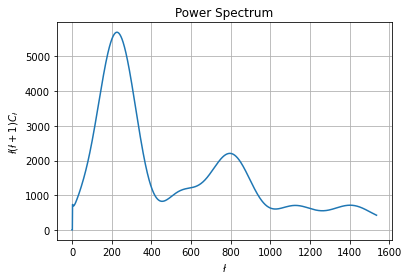

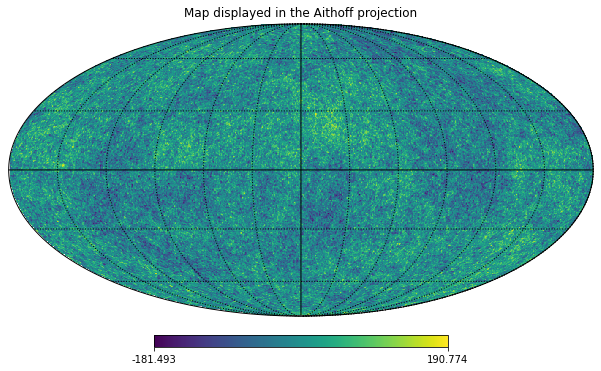

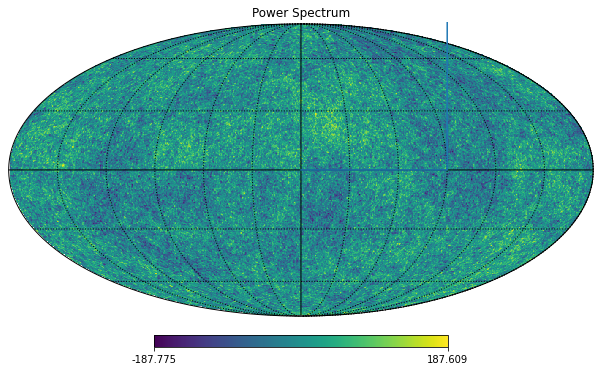

In [25]:
#Trial with parameters 1
parameters1 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax1 = 1536  #lmax value wanted from data
NSIDE1 = int(lmax1/3)  #len(cls1)/3   #3*nside = len(cls)
n1 = np.linspace(5,5,(12*(NSIDE1)**2))
Ninv1 = []
for i in range(len(n1)):
    Ninv1.append(1/(n1[i]**2)) #finds the inverse noise matrix

cls1 = call_CAMB_map(parameters1, lmax1) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls1) #plot of the power spectrum.
map1 = hpcltomap(cls1, NSIDE1)  #generates a map from the power spectrum
map1 = hpmapsmooth(map1, lmax1) #applies a gaussian beam smoother to the map
mollviewmap(map1) #plots the map
noisemap1 = noisemapfunc(list(map1),n1[0])[0] #adds noise to the map
mollviewmap(noisemap1) #plots the map with noise
hnoisealms1 = hpmaptoalm(noisemap1,lmax1) #computes the alms from the map with noise added.
noisecl1 = hpalmtocl(hnoisealms1, lmax1) #estimates the power spectrum from the given alms.
plotpwrspctrm(noisecl1) #plots the estimated power spectrum.


/usr/local/lib/python3.6/dist-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/usr/local/lib/python3.6/dist-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


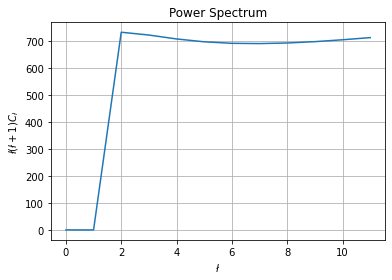

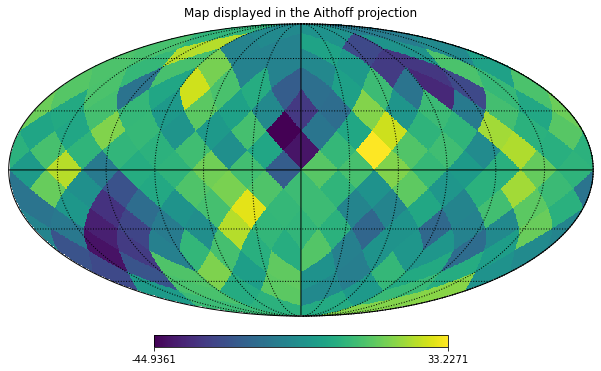

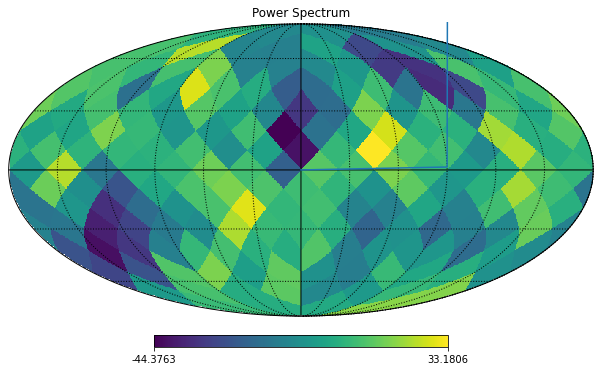

In [107]:
#Trial with parameters 2
parameters2 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax2 = 12   #lmax value wanted from data
NSIDE2 = int(lmax2/3)   #len(cls1)/3   #3*nside = len(cls)
n2 = np.linspace(0.5,0.5,(12*(NSIDE2)**2))
Ninv2 = []
for i in range(len(n2)):
    Ninv2.append(1/(n2[i]**2)) #finds the inverse noise matrix
    

cls2 = call_CAMB_map(parameters2, lmax2) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls2) #plot of the power spectrum.
map2 = hpcltomap(cls2, NSIDE2)  #generates a map from the power spectrum
map2 = hpmapsmooth(map2, lmax2) #applies a gaussian beam smoother to the map
mollviewmap(map2) #plots the map
noisemap2 = noisemapfunc(map2,n2[0])[0] #adds noise to the map
mollviewmap(noisemap2) #plots the map with noise
hnoisealms2 = hpmaptoalm(noisemap2,lmax2-1) #computes the alms from the map with noise added.
noisecl2 = hpalmtocl(hnoisealms2, lmax2-1) #estimates the power spectrum from the given alms.
plotpwrspctrm(noisecl2) #plots the estimated power spectrum.


/usr/local/lib/python3.6/dist-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/usr/local/lib/python3.6/dist-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


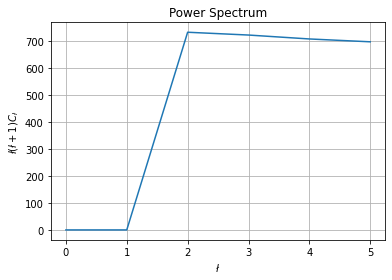

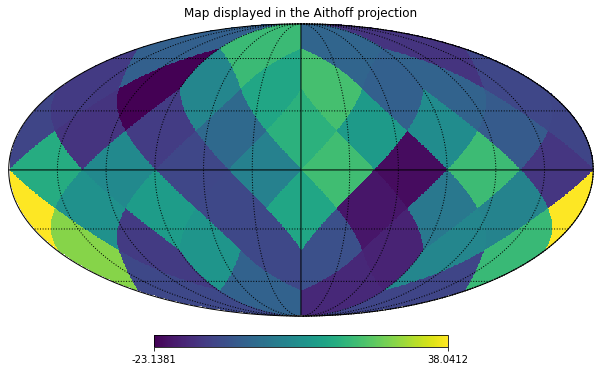

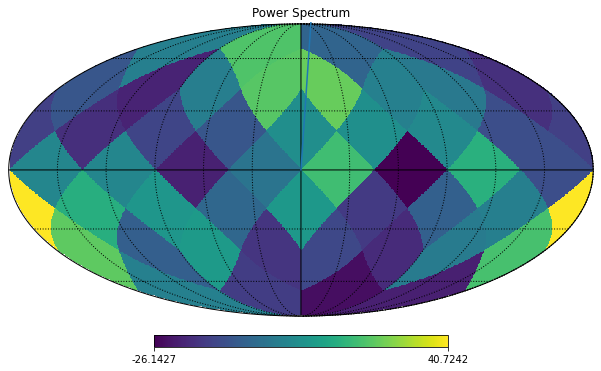

In [20]:
#Trial with parameters 3
parameters3 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax3 = 6  #lmax value wanted from data
NSIDE3 = int(lmax3/3)  #len(cls1)/3   #3*nside = len(cls)
n3 = np.linspace(5,5,(12*(NSIDE3)**2))
Ninv3 = []
for i in range(len(n3)):
    Ninv3.append(1/(n3[i]**2)) #finds the inverse noise matrix

cls3 = call_CAMB_map(parameters3, lmax3) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls3) #plot of the power spectrum.
map3 = hpcltomap(cls3, NSIDE3)  #generates a map from the power spectrum
map3 = hpmapsmooth(map3, lmax3) #applies a gaussian beam smoother to the map
mollviewmap(map3) #plots the map
noisemap3 = noisemapfunc(map3,n3[0])[0] #adds noise to the map
mollviewmap(noisemap3) #plots the map with noise
hnoisealms3 = hpmaptoalm(noisemap3,lmax3-1) #computes the alms from the map with noise added.
noisecl3 = hpalmtocl(hnoisealms3, lmax3-1) #estimates the power spectrum from the given alms.
plotpwrspctrm(noisecl3) #plots the estimated power spectrum.

/usr/local/lib/python3.6/dist-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/usr/local/lib/python3.6/dist-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


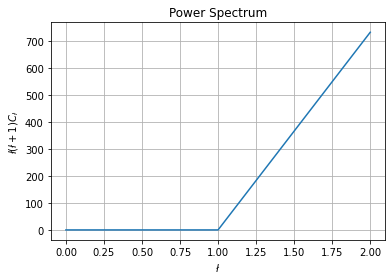

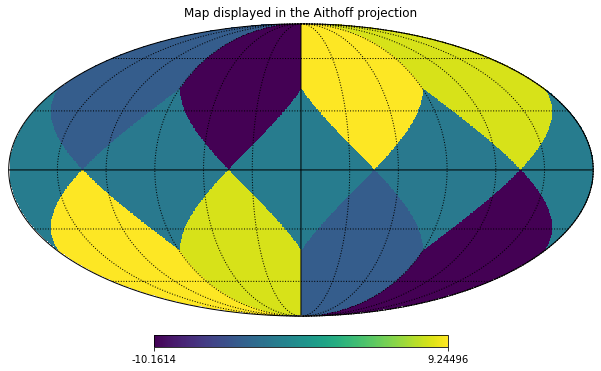

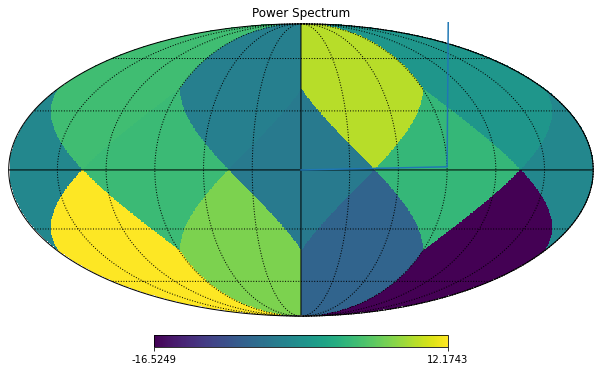

In [109]:
#Trial with parameters 4
parameters4 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax4 = 3  #lmax value wanted from data
NSIDE4 = int(lmax4/3)  #len(cls1)/3   #3*nside = len(cls)
n4 = np.linspace(5,5,(12*(NSIDE4)**2))
Ninv4 = []
for i in range(len(n4)):
    Ninv4.append(1/(n4[i]**2)) #finds the inverse noise matrix
    
cls4 = call_CAMB_map(parameters4, lmax4) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls4) #plot of the power spectrum.
map4 = hpcltomap(cls4, NSIDE4)  #generates a map from the power spectrum
map4 = hpmapsmooth(map4, lmax4) #applies a gaussian beam smoother to the map
mollviewmap(map4)
noisemap4 = noisemapfunc(map4,n4[0])[0] #adds noise to the map
mollviewmap(noisemap4)
hnoisealms4 = maptoalm(noisemap4) #alms in my ordering
noisecl4 = almtocl(hnoisealms4, lmax4) #
plotpwrspctrm(noisecl4) #plots the estimated power spectrum.


In [110]:
#inital values for the optimisation of psi (with the values from parameters4)
_number = 2

if _number == 1:
    lmax = lmax1
    noisemap = noisemap1
    clinit = noisecl1
    noisealm = almhotmo(hnoisealms1,lmax)
    Ninv = Ninv1
    orig_map = map1
    orig_cls = cls1
if _number == 2:
    lmax = lmax2
    noisemap = noisemap2
    clinit = noisecl2
    noisealm = almhotmo(hnoisealms2,lmax)
    Ninv = Ninv2
    orig_map = map2
    orig_cls = cls2
if _number == 3:
    lmax = lmax3
    noisemap = noisemap3
    clinit = noisecl3
    noisealm = almhotmo(hnoisealms3,lmax)
    Ninv = Ninv3
    orig_map = map3
    orig_cls = cls3
if _number == 4:
    lmax = lmax4
    noisemap = noisemap4
    clinit = noisecl4
    noisealm = almhotmo(hnoisealms4,lmax)
    Ninv = Ninv4
    orig_map = map4
    orig_cls = cls4

NSIDE = int(lmax/3)
_sph = []
for i in range(int((lmax**2)*4/3)):
    _sph.append([])
    _count = 0
    for l in range(lmax):
        for m in range(l+1):
            _theta, _phi = hp.pix2ang(nside=NSIDE, ipix=i)
            _sph[i].append(sp.special.sph_harm(m, l, _phi, _theta))
            if l==0:    
                _sph[i][_count] = np.complex(np.real(_sph[i][_count]),np.float64(0.0))
            _count = _count + 1 
_sph = tf.convert_to_tensor(_sph, dtype = np.complex128)
noisemap_tf = tf.convert_to_tensor(noisemap, dtype = np.float64)
realalminit = noisealm.real
imagalminit = noisealm.imag
x0 = []
len_cl = len(clinit)
len_ralm = len(realalminit)
len_ialm = len(imagalminit)
shape = multtensor(lmax,len_ralm) #A tensor for the spherical harmonics in the maptoalm_tf function
for i in range(len(clinit)):
    if clinit[i] > 0:
        x0.append(np.log(clinit[i]))
    else:
        x0.append(0)
for i in range(len(realalminit)):
    x0.append(realalminit[i])
for i in range(len(imagalminit)):
    x0.append(imagalminit[i])
psi(x0,noisemap,lmax,Ninv)
x0_tf = tf.convert_to_tensor(x0, dtype = np.float64)
psi_tf(x0_tf)


psi = 398.4586050353811
psi = tf.Tensor(395.24953451631006, shape=(), dtype=float64)


<tf.Tensor: shape=(), dtype=float64, numpy=-395.24953451631006>

In [ ]:
#Optimising the parameters of the posterior (the 'psi' funciton), to get the parameters corresponding to its min.
#'''
sp.optimize.fmin(psi, x0, args = (noisemap, lmax, Ninv), xtol=5)
#'''


In [ ]:
samples = tf.constant([[ 2.83978241e+00, -5.00359749e-01,  4.44681554e+00,  3.61544380e+00,
        3.67323404e+00, -5.25171853e+00,  4.26966879e+00,  1.03327050e+00,
        1.47001944e-01, -8.93175019e+00,  4.85881550e+00, -5.20127495e+00,
       -5.05121328e+00,  3.18495045e+00, -3.13826517e+00, -7.07795662e-01,
       -1.99806265e+00,  5.40446157e+00, -3.43190582e+00, -1.89387087e+00,
        5.98625373e-01,  5.46167621e-03, -1.85727197e-03,  1.12167586e-03,
        6.80635644e-03, -2.74614931e-03,  3.90693936e-03,  1.37876275e-02,
        1.89907446e-02, -2.13836179e-01, -1.55465977e-02, -7.54526829e+00,
       -4.90761874e+00, -2.28154296e-03,  1.58095688e+00, -3.65681637e-01,
       -8.30760112e+00,  2.45040763e-03,  2.39531164e+00,  8.66370670e+00,
        6.39774583e+00,  3.42134777e+00,  1.44687781e-02, -1.04394047e-01,
       -9.82495128e-02,  5.36604451e-03,  4.28013439e-03, -1.92494742e-03]])

In [90]:
def run_chain1(initial_state, num_results=50, num_burnin_steps=0): 
    '''Returns the desired walks through parameter space for a fixed step size.'''
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                               current_state=initial_state, kernel=hmc_kernel, trace_fn=lambda current_state,
                               kernel_results: kernel_results)


hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=psi_tf, step_size=0.1, num_leapfrog_steps=5)#, state_gradients_are_stopped=True)



samples1, kernel_results1 = run_chain1(x0_tf) #Begins Sampling with a fixed step-size
print("Acceptance rate:", kernel_results1.is_accepted.numpy().mean()) 


psi = tf.Tensor(138.28436131701548, shape=(), dtype=float64)
psi = tf.Tensor(138.28436131701548, shape=(), dtype=float64)
psi = tf.Tensor(110.56083273763288, shape=(), dtype=float64)
psi = tf.Tensor(110.56083273763288, shape=(), dtype=float64)
psi = tf.Tensor(74.18823063616865, shape=(), dtype=float64)
psi = tf.Tensor(74.18823063616865, shape=(), dtype=float64)
psi = tf.Tensor(53.764251014781564, shape=(), dtype=float64)
psi = tf.Tensor(53.764251014781564, shape=(), dtype=float64)
psi = tf.Tensor(45.63796877702078, shape=(), dtype=float64)
psi = tf.Tensor(45.63796877702078, shape=(), dtype=float64)
psi = tf.Tensor(43.58193825965151, shape=(), dtype=float64)
psi = tf.Tensor(43.58193825965151, shape=(), dtype=float64)
psi = tf.Tensor(43.87717651394581, shape=(), dtype=float64)
psi = tf.Tensor(43.87717651394581, shape=(), dtype=float64)
psi = tf.Tensor(44.19012618774369, shape=(), dtype=float64)
psi = tf.Tensor(44.19012618774369, shape=(), dtype=float64)
psi = tf.Tensor(44.51721466751798,

In [91]:
def run_chain2(_initial_state, num_results=50, num_burnin_steps=0):
    '''Uses HMC to step through parameter space with an adaptive step size.'''
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(hmc_kernel,
                                                        num_adaptation_steps=int(.8 * num_burnin_steps),
                                                        target_accept_prob=np.float64(.65))
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps,
                                 current_state=_initial_state, kernel=adaptive_kernel,
                                 trace_fn=lambda cs, kr: kr)


samples2, kernel_results2 = run_chain2(x0_tf) #Begins Sampling with a variable step size
print("Acceptance rate:", kernel_results2.inner_results.is_accepted.numpy().mean())

psi = tf.Tensor(138.28436131701548, shape=(), dtype=float64)
psi = tf.Tensor(138.28436131701548, shape=(), dtype=float64)
psi = tf.Tensor(111.76653491968318, shape=(), dtype=float64)
psi = tf.Tensor(111.76653491968318, shape=(), dtype=float64)
psi = tf.Tensor(75.553617388212, shape=(), dtype=float64)
psi = tf.Tensor(75.553617388212, shape=(), dtype=float64)
psi = tf.Tensor(55.82141401076994, shape=(), dtype=float64)
psi = tf.Tensor(55.82141401076994, shape=(), dtype=float64)
psi = tf.Tensor(48.244995078833796, shape=(), dtype=float64)
psi = tf.Tensor(48.244995078833796, shape=(), dtype=float64)
psi = tf.Tensor(46.24663740104597, shape=(), dtype=float64)
psi = tf.Tensor(46.24663740104597, shape=(), dtype=float64)
psi = tf.Tensor(46.97467533018148, shape=(), dtype=float64)
psi = tf.Tensor(46.97467533018148, shape=(), dtype=float64)
psi = tf.Tensor(47.50446904293061, shape=(), dtype=float64)
psi = tf.Tensor(47.50446904293061, shape=(), dtype=float64)
psi = tf.Tensor(47.68644343477362, sha

In [117]:
def run_chain3(initial_state, num_results=150, num_burnin_steps=0): 
    '''Returns the desired walks through parameter space for a fixed step size.'''
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                               current_state=initial_state, kernel=nut_kernel, trace_fn=lambda current_state,
                               kernel_results: kernel_results)


nut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=psi_tf, step_size=0.1, max_tree_depth=10, max_energy_diff=1000.0, unrolled_leapfrog_steps=1, parallel_iterations=10)
samples3, kernel_results3 = run_chain3(x0_tf) #Runs the chain
print("Acceptance rate:", kernel_results3.is_accepted.numpy().mean()) 

'''
nut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=psi_tf, step_size=20.0, max_tree_depth=10, max_energy_diff=1000.0, unrolled_leapfrog_steps=1, parallel_iterations=10)
samples4, kernel_results4 = run_chain3(x0_tf) #Runs the chain
print("Acceptance rate:", kernel_results4.is_accepted.numpy().mean()) 


nut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=psi_tf, step_size=0.001, max_tree_depth=10, max_energy_diff=1000.0, unrolled_leapfrog_steps=1, parallel_iterations=10)
samples5, kernel_results5 = run_chain3(x0_tf) #Runs the chain
print("Acceptance rate:", kernel_results5.is_accepted.numpy().mean()) 


nut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=psi_tf, step_size=0.1, max_tree_depth=50, max_energy_diff=1000.0, unrolled_leapfrog_steps=1, parallel_iterations=10)
samples6, kernel_results6 = run_chain3(x0_tf) #Runs the chain
print("Acceptance rate:", kernel_results6.is_accepted.numpy().mean()) 


nut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=psi_tf, step_size=0.1, max_tree_depth=1, max_energy_diff=1000.0, unrolled_leapfrog_steps=1, parallel_iterations=10)
samples7, kernel_results7 = run_chain3(x0_tf) #Runs the chain
print("Acceptance rate:", kernel_results7.is_accepted.numpy().mean()) 


nut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=psi_tf, step_size=0.1, max_tree_depth=10, max_energy_diff=1.0, unrolled_leapfrog_steps=1, parallel_iterations=10)
samples8, kernel_results8 = run_chain3(x0_tf) #Runs the chain
print("Acceptance rate:", kernel_results8.is_accepted.numpy().mean()) 


nut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=psi_tf, step_size=0.1, max_tree_depth=10, max_energy_diff=10000.0, unrolled_leapfrog_steps=1, parallel_iterations=10)
samples9, kernel_results9 = run_chain3(x0_tf) #Runs the chain
print("Acceptance rate:", kernel_results9.is_accepted.numpy().mean()) 


nut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=psi_tf, step_size=0.1, max_tree_depth=10, max_energy_diff=1000.0, unrolled_leapfrog_steps=10, parallel_iterations=10)
samples10, kernel_results10 = run_chain3(x0_tf) #Runs the chain
print("Acceptance rate:", kernel_results10.is_accepted.numpy().mean()) 


nut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=psi_tf, step_size=0.1, max_tree_depth=10, max_energy_diff=1000.0, unrolled_leapfrog_steps=1, parallel_iterations=1)
samples11, kernel_results11 = run_chain3(x0_tf) #Runs the chain
print("Acceptance rate:", kernel_results11.is_accepted.numpy().mean()) 
'''

Streaming output truncated to the last 5000 lines.
psi = tf.Tensor(486.2833929676842, shape=(), dtype=float64)
psi = tf.Tensor(491.53017972143357, shape=(), dtype=float64)
psi = tf.Tensor(491.53017972143357, shape=(), dtype=float64)
psi = tf.Tensor(488.3359528873825, shape=(), dtype=float64)
psi = tf.Tensor(488.3359528873825, shape=(), dtype=float64)
psi = tf.Tensor(480.5140078841247, shape=(), dtype=float64)
psi = tf.Tensor(480.5140078841247, shape=(), dtype=float64)
psi = tf.Tensor(487.65721677775315, shape=(), dtype=float64)
psi = tf.Tensor(487.65721677775315, shape=(), dtype=float64)
psi = tf.Tensor(485.5817681951158, shape=(), dtype=float64)
psi = tf.Tensor(485.5817681951158, shape=(), dtype=float64)
psi = tf.Tensor(489.491467186104, shape=(), dtype=float64)
psi = tf.Tensor(489.491467186104, shape=(), dtype=float64)
psi = tf.Tensor(483.2225215739445, shape=(), dtype=float64)
psi = tf.Tensor(483.2225215739445, shape=(), dtype=float64)
psi = tf.Tensor(487.4559180532141, shape=(), dt

'\nnut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=psi_tf, step_size=20.0, max_tree_depth=10, max_energy_diff=1000.0, unrolled_leapfrog_steps=1, parallel_iterations=10)\nsamples4, kernel_results4 = run_chain3(x0_tf) #Runs the chain\nprint("Acceptance rate:", kernel_results4.is_accepted.numpy().mean()) \n\n\nnut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=psi_tf, step_size=0.001, max_tree_depth=10, max_energy_diff=1000.0, unrolled_leapfrog_steps=1, parallel_iterations=10)\nsamples5, kernel_results5 = run_chain3(x0_tf) #Runs the chain\nprint("Acceptance rate:", kernel_results5.is_accepted.numpy().mean()) \n\n\nnut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=psi_tf, step_size=0.1, max_tree_depth=50, max_energy_diff=1000.0, unrolled_leapfrog_steps=1, parallel_iterations=10)\nsamples6, kernel_results6 = run_chain3(x0_tf) #Runs the chain\nprint("Acceptance rate:", kernel_results6.is_accepted.numpy().mean()) \n\n\nnut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn

In [118]:
samples = samples3
#print('Samples:', samples) #print the samples from the adaptive step size HMC


In [119]:
rhat = tfp.mcmc.diagnostic.potential_scale_reduction(samples, independent_chain_ndims=1)   #int((len(clinit) + len(realalminit)))) #maybe ndims = len(cl) + len(alm)
print('Gelman Rubin =', rhat)

Gelman Rubin = tf.Tensor(1.8940892044685547, shape=(), dtype=float64)


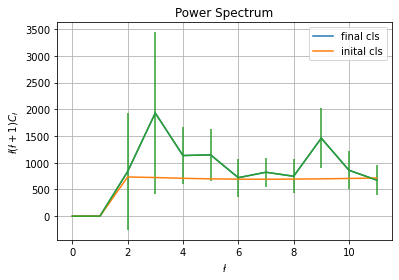

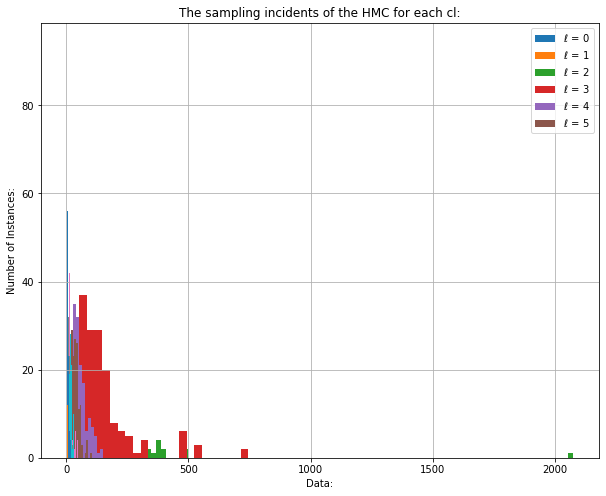

In [120]:
lncl_samples = tf.slice(samples,[0,0],[len(samples),lmax]) #The sampled cls from the adaptive step size HMC
cl_samples = tf.math.exp(lncl_samples)
mean_cl = [tf.math.reduce_mean(cl_samples[:,i])  for i in range(lmax)] #The mean of the sampled cls from the adaptive step size HMC
std_cl = [tf.math.reduce_std(cl_samples[:,i])  for i in range(lmax)] #The standard deviation of the = sampled cls from the adaptive step size HMC
plt.figure()
plotpwrspctrm(mean_cl) # Plot of the mean sampled cls
plotpwrspctrm(orig_cls) #Plot of the original cls
ell = np.arange(lmax)
plt.errorbar(ell,(ell*(ell+1)*mean_cl),xerr = 0, yerr = (ell*(ell+1)*std_cl))
plt.grid()
plt.legend(('final cls','inital cls'))
plt.show()

plt.figure(figsize = [10,8])
[plt.hist((cl_samples[:,i].numpy()), bins = 'auto') for i in range(lmax)] #Histogram of the sampled cls for each l value.
plt.legend((r'$\ell$ = 0','$\ell$ = 1','$\ell$ = 2','$\ell$ = 3','$\ell$ = 4','$\ell$ = 5'))
plt.grid()
plt.xlabel('Data:')
plt.ylabel('Number of Instances:')
plt.title('The sampling incidents of the HMC for each cl:')
plt.show()


In [ ]:
ralm_samples = tf.slice(samples,[0,lmax],[len(samples),len_ralm]) #The real alm samples from the adaptive step size HMC
ialm_samples = tf.slice(samples,[0,(lmax + len_ralm)],[len(samples),len_ralm]) #The imaginary alm samples from the adaptive step size HMC
mean_ralm = [tf.math.reduce_mean(ralm_samples[:,i])  for i in range(len_ralm)] #The mean of all the samples from the real alms
mean_ialm = [tf.math.reduce_mean(ialm_samples[:,i])  for i in range(len_ralm)] #The mean of all the samples from the imaginary alms
std_ralm = [tf.math.reduce_std(ralm_samples[:,i])  for i in range(len_ralm)] #The standard deviation of all the samples from the real alms
std_ialm = [tf.math.reduce_std(ialm_samples[:,i])  for i in range(len_ralm)] #The standard deviation of all the samples from the imaginary alms
mean_alm = splittosingularalm_tf(mean_ralm, mean_ialm) 
hmean_alm = almmotho(mean_alm,lmax)
mean_map = almtomap(hmean_alm,NSIDE) #The mean samples from the HMC as a map

mollviewmap(orig_map) #Plot of the original map
mollviewmap(mean_map) #Plot of the mean samples from the HMC as a map
mollviewmap(abs(orig_map - mean_map)) #A plot of the difference between the original and sampled maps.
print('Original Map =',orig_map)
print('Estimated Map =',mean_map)

In [ ]:
for i in range(lmax):
    plt.figure(figsize = [10,8])
    plt.hist((cl_samples[:,i].numpy()))  #Histogram of the sampled cls for each l value.
    plt.grid()
    plt.xlabel('Data:')
    plt.ylabel('Number of Instances:')
    plt.title('The sampling incidents of the HMC for each cl:')
    plt.show()

In [101]:
rhat1 = tfp.mcmc.diagnostic.potential_scale_reduction(samples1, independent_chain_ndims=1)   #int((len(clinit) + len(realalminit)))) #maybe ndims = len(cl) + len(alm)
print('Gelman Rubin =',rhat1) #normal hmc sampler

Gelman Rubin = tf.Tensor(44.928587798806525, shape=(), dtype=float64)


In [99]:
rhat2 = tfp.mcmc.diagnostic.potential_scale_reduction(samples2, independent_chain_ndims=1)   #int((len(clinit) + len(realalminit)))) #maybe ndims = len(cl) + len(alm)
print('Gelman Rubin =',rhat2) #adaptive step size sampler

Gelman Rubin = tf.Tensor(38.669378155724296, shape=(), dtype=float64)


In [104]:
rhat3 = tfp.mcmc.diagnostic.potential_scale_reduction(samples3, independent_chain_ndims=1)   #int((len(clinit) + len(realalminit)))) #maybe ndims = len(cl) + len(alm)
print('Gelman Rubin =',rhat3) #nut sampler

Gelman Rubin = tf.Tensor(1.7181056100136536, shape=(), dtype=float64)


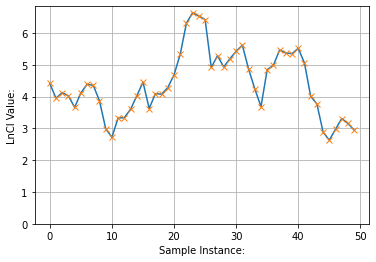

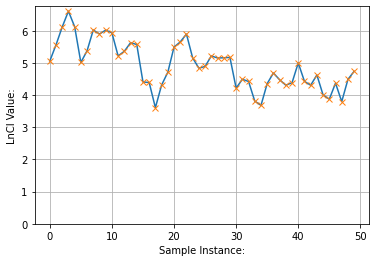

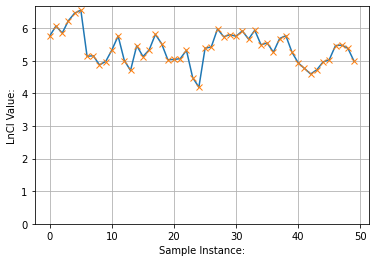

In [95]:
#Cl trace plots for the fixed step size hmc
ex = np.arange(len(lncl_samples))
for i in range(len_cl):
  plt.figure()
  plt.plot(ex,lncl_samples[:,i])
  plt.plot(ex,lncl_samples[:,i],'x')
  plt.xlabel('Sample Instance:')
  plt.ylabel('LnCl Value:')
  plt.grid()
  plt.ylim(ymin = 0)
  plt.show()

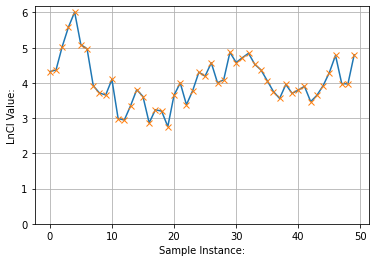

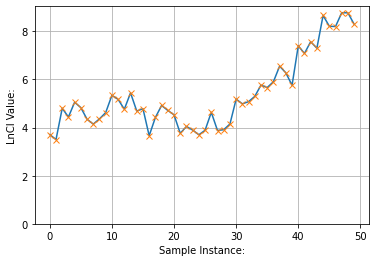

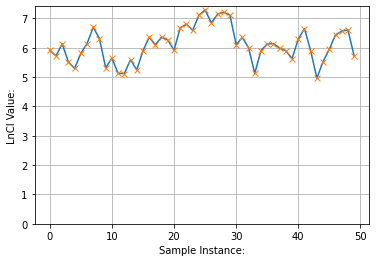

In [98]:
#Cl trace plots for the variable step size hmc
ex = np.arange(len(lncl_samples)) 
for i in range(len_cl):
  plt.figure()
  plt.plot(ex,lncl_samples[:,i])
  plt.plot(ex,lncl_samples[:,i],'x')
  plt.xlabel('Sample Instance:')
  plt.ylabel('LnCl Value:')
  plt.grid()
  plt.ylim(ymin = 0)
  plt.show()

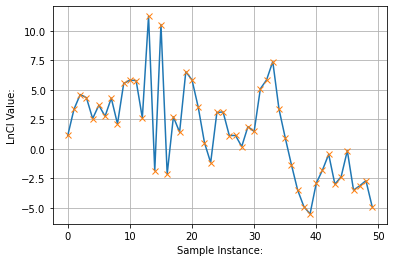

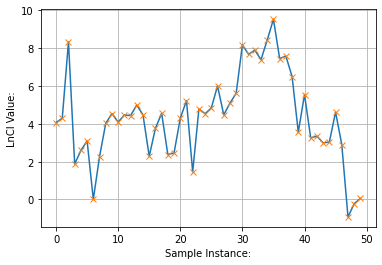

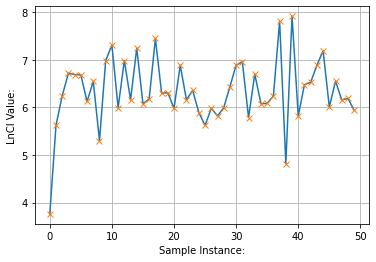

In [105]:
#Cl trace plots for the no U turn sampler
ex = np.arange(len(lncl_samples))
for i in range(len_cl):
  plt.figure()
  plt.plot(ex,lncl_samples[:,i])
  plt.plot(ex,lncl_samples[:,i],'x')
  plt.xlabel('Sample Instance:')
  plt.ylabel('LnCl Value:')
  plt.grid()
  #plt.ylim(ymin = 0)
  plt.show()

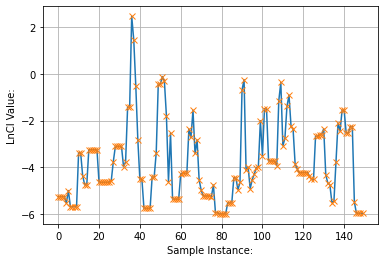

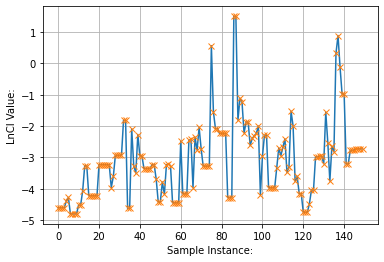

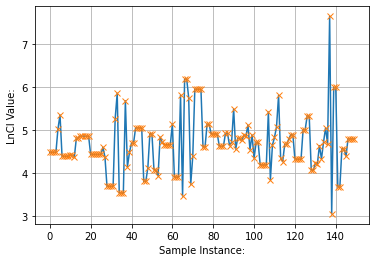

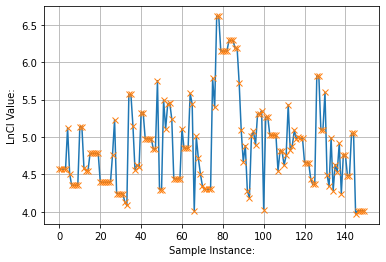

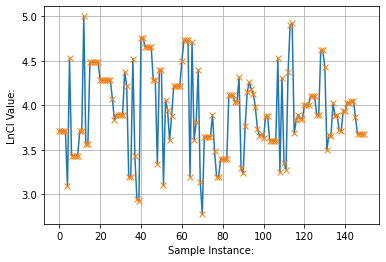

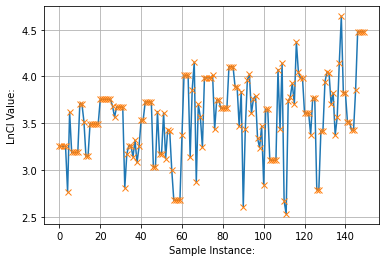

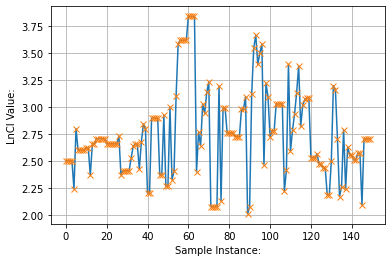

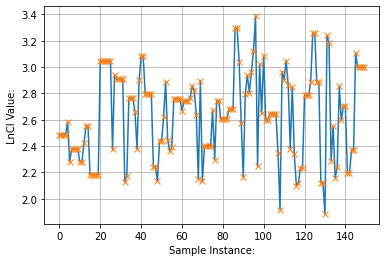

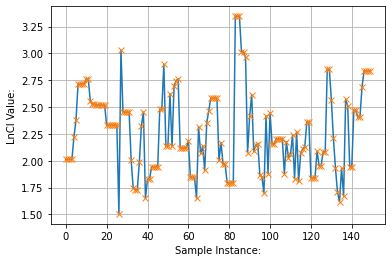

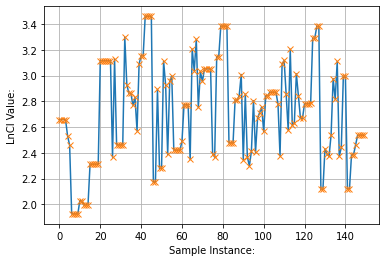

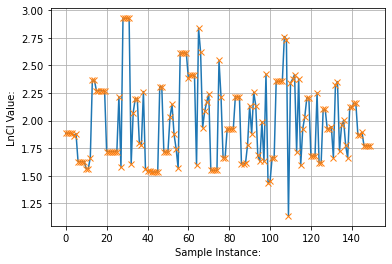

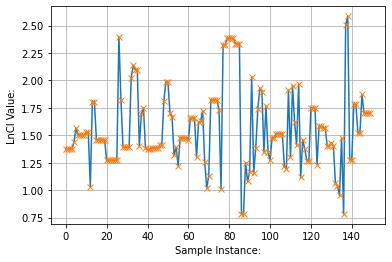

In [121]:
#Cl trace plots for the no U turn sampler (with lmax = 12)
ex = np.arange(len(lncl_samples))
for i in range(len_cl):
  plt.figure()
  plt.plot(ex,lncl_samples[:,i])
  plt.plot(ex,lncl_samples[:,i],'x')
  plt.xlabel('Sample Instance:')
  plt.ylabel('LnCl Value:')
  plt.grid()
  #plt.ylim(ymin = 0)
  plt.show()

In [ ]:
#[insert here where your maps are coming from]


# loop over samples (what we want!)
#saves the frames:
Maps = [noisemap1,noisemap2]
i = 0
for s in Maps:
    # s[0] is the first bin!
    hp.mollview(s[1][0], min=-0.0115, max=0.0115, title="Bin 2 - $\kappa_1$ ")
    N = str(i).zfill(3)
    plty.savefig(f'/path/to/saving/frames/Kappa_2-frame-{N}.png', bbox_to_inches='tight')
    plty.close()
    i += 1

# Creates the gif:
# filepaths
fp_in = "/path/to/saving/frames/Kappa_2-frame-*.png"
fp_out = "/path/to/saving/gifs/kappa_2.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=80, loop=0, optimize=False)


In [52]:
#the negative log posterior - 'psi', with each term individually returned
def term1_psi(_params, _map, _lmax, _Ninv): #unnormalised log probability
    _lncl, _realalm, _imagalm = [], [], []
    for i in range(len_cl):
        _lncl.append(_params[i])
    for i in range(len_ralm):
        _realalm.append(_params[i + len_cl])
    for i in range(len_ialm):
        _imagalm.append(_params[i + len_cl + len_ralm])
    _imagalm[0] = 0.0 
    _d = _map
    _a = splittosingularalm(_realalm, _imagalm)
    _Ya = almtomap(_a, int(_lmax/3))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    _elem, _term1, _term2, _psi1 = [], [], [], []
    _sum = 0
    for i in range(len(_d)):
        _elem.append(_d[i] - _BYa[i])
        _psi1.append(0.5*(_elem[i]**2)*_Ninv[i]) #first term in the taylor paper 
    return [sum(_psi1),_psi1]   
    
def term2_psi(_params, _map, _lmax, _Ninv): #unnormalised log probability
    _lncl, _realalm, _imagalm = [], [], []
    for i in range(len_cl):
        _lncl.append(_params[i])
    for i in range(len_ralm):
        _realalm.append(_params[i + len_cl])
    for i in range(len_ialm):
        _imagalm.append(_params[i + len_cl + len_ralm])
    _elem, _term1, _term2, _psi2 = [], [], [], []
    _l = np.arange(_lmax)
    for i in range(len(_lncl)):
        _psi2.append((_l[i] + 0.5)*(_lncl[i])) #second term in the taylor paper 
    return[sum(_psi2),_psi2]



def term1_psi_tf(_params):
    _map, _lmax, _Ninv = noisemap_tf, lmax, Ninv
    _lncl = _params[:len_cl]
    _realalm = _params[len_cl:(len_ralm + len_cl)]
    _imagalm = _params[(len_ralm + len_cl):]
    _term1, _term2 = tf.slice(_imagalm, [0], [1]), tf.zeros(len(_imagalm)-1, dtype = np.float64)
    _term3 = tf.concat([_term1,_term2], axis = 0)
    _imagalm = _imagalm - _term3
    _d = _map
    _a = splittosingularalm_tf(_realalm, _imagalm)
    _Ya = almtomap_tf3(_a, int(_lmax/3))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    _elem = _d - _BYa
    _psi1 = 0.5*(_elem**2)*_Ninv #first term in the taylor paper 
    return [tf.compat.v1.reduce_sum(_psi1).numpy(),_psi1.numpy()]

def term2_psi_tf(_params):
    _map, _lmax, _Ninv = noisemap_tf, lmax, Ninv
    _lncl = _params[:len_cl]
    _realalm = _params[len_cl:(len_ralm + len_cl)]
    _imagalm = _params[(len_ralm + len_cl):]
    _term1, _term2 = tf.slice(_imagalm, [0], [1]), tf.zeros(len(_imagalm)-1, dtype = np.float64)#
    _term3 = tf.concat([_term1,_term2], axis = 0)
    _imagalm = _imagalm - _term3    
    _l = tf.range(_lmax, dtype = np.float64)
    _psi2 = (_l+0.5)*_lncl #second term in the taylor paper 
    return [tf.reduce_sum(_psi2).numpy(),_psi2.numpy()]

def term3_psi(_params, _map, _lmax, _Ninv): #unnormalised log probability
    _lncl, _realalm, _imagalm = [], [], []
    for i in range(len_cl):
        _lncl.append(_params[i])
    for i in range(len_ralm):
        _realalm.append(_params[i + len_cl])
    for i in range(len_ialm):
        _imagalm.append(_params[i + len_cl + len_ralm])
    _imagalm[0] = 0.0 
    _a = splittosingularalm(_realalm, _imagalm)
    _elem, _term1, _term2,_psi3 = [], [], [], []
    _sum = 0
    for i in range(len(_lncl)):
        _term1.append([])
        for j in range(i+1):
            if j == _sum:
                _term1[i].append(np.absolute(_a[_sum])**2)
                _sum = _sum + 1
            else:
                _term1[i].append(2*np.absolute(_a[_sum])**2)
                _sum = _sum + 1
            if j == i:
                _term2.append(sum(_term1[i])) 
    for i in range(len(_lncl)):
        _psi3.append(_term2[i]/(2*np.exp(_lncl[i]))) #third term in the taylor paper
    return [sum(_psi3),_psi3]


def term3_psi_tf(_params):
    _map, _lmax, _Ninv = noisemap_tf, lmax, Ninv
    _lncl = _params[:len_cl]
    _realalm = _params[len_cl:(len_ralm + len_cl)]
    _imagalm = _params[(len_ralm + len_cl):]
    _term1, _term2 = tf.slice(_imagalm, [0], [1]), tf.zeros(len(_imagalm)-1, dtype = np.float64)#
    _term3 = tf.concat([_term1,_term2], axis = 0)
    _imagalm = _imagalm - _term3
    _a = splittosingularalm_tf(_realalm, _imagalm)
    _a = tf.math.abs(_a)**2
    _as = tf.linalg.matvec(shape,_a)
    _psi3 = 0.5*_as/tf.math.exp(_lncl) #third term in the taylor paper 
    return [tf.reduce_sum(_psi3).numpy(),_psi3.numpy()]


In [56]:
#Validity checking of the functions:
m_cltoalm_test = cltoalm(orig_cls,NSIDE)
h_cltoalm_test = almhotmo(hpcltoalm(orig_cls,NSIDE),lmax)
if m_cltoalm_test == h_cltoalm_test:
    print('cltoalm verified')
else:
    print('cltoalm not verified')
#    print('m_cltoalm_test =', m_cltoalm_test)
#    print('h_cltoalm_test =',h_cltoalm_test)
  
    
m_cltomap_test = cltomap(orig_cls,NSIDE)
h_cltomap_test = hpcltomap(orig_cls,NSIDE)
if np.all([m_cltomap_test[i] == h_cltomap_test[i] for i in range(len(m_cltomap_test))]): 
    print('cltomap verified')
else:
    print('cltomap not verified')
    print('m_cltomap_test =', m_cltomap_test)
    print('h_cltomap_test =',h_cltomap_test)
    
    
#m_maptocl_test = maptocl(orig_map)
#h_maptocl_test = hpmaptocl(orig_map)
#if m_maptocl_test == h_maptocl_test:
#    print('maptocl verified')
#else:
#    print('maptocl not verified')   


m_maptoalm_test = maptoalm(orig_map)
h_maptoalm_test = almhotmo(hpmaptoalm(orig_map,lmax),lmax)
if np.all([m_maptoalm_test == h_maptoalm_test for i in range(len(m_maptoalm_test))]):
    print('maptoalm verified')
else:
    print('maptoalm not verified') 
    print('m_maptoalm_test =', m_maptoalm_test)
    print('h_maptoalm_test =', h_maptoalm_test)
    

m_almtocl_test = almtocl(noisealm,lmax)
h_almtocl_test = hpalmtocl(almhotmo(noisealm,lmax),lmax-1)
if np.all([m_almtocl_test == h_almtocl_test for i in range(len(m_almtocl_test))]):
    print('almtocl verified')
else:
    print('almtocl not verified') 
    print('m_almtocl_test =', m_almtocl_test)
    print('h_almtocl_test', h_almtocl_test)
    
    
m_almtomap_test = almtomap(noisealm,NSIDE)
h_almtomap_test = hpalmtomap(almmotho(noisealm,lmax),NSIDE)
if np.all([m_almtomap_test == h_almtomap_test for i in range(len(m_almtomap_test))]):
    print('almtomap verified')
else:
    print('almtomap not verified') 
    print('m_almtomap_test =',m_almtomap_test)
    print('h_almtomap_test =', h_almtomap_test)

    
almtomap_tf_test = almtomap_tf3(tf.convert_to_tensor(noisealm, dtype = np.complex128),NSIDE).numpy()
if np.all([m_almtomap_test == almtomap_tf_test for i in range(len(m_almtomap_test))]):
    print('almtomap_tf verified')
else:
    print('almtomap_tf not verified') 
    print('m_almtomap_test =',m_almtomap_test)
    print('almtomap_tf_test =', almtomap_tf_test)
    
    
if [x0[i] == x0_tf.numpy()[i] for i in range(len(x0))]:
    print('x0_tf verified')
else:
    print('x0_tf not verified')
    print('x0 =', x0)
    print('x0_tf =',x0_tf)
    
    
term1_psi_test = term1_psi(x0,noisemap,lmax,Ninv)
term1_psi_tf_test = term1_psi_tf(x0_tf)
if term1_psi_test[0] == term1_psi_tf_test[0]:
    print('term1_sum_psi_tf verified')
else:
    print('term1_sum_psi_tf not verified')
    print('term1_sum_psi =', term1_psi_test[0])
    print('term1_sum_psi_tf =', term1_psi_tf_test[0])
if np.all([term1_psi_test[1][i] == term1_psi_tf_test[1][i] for i in range(len(term1_psi_test[1]))]):
    print('term1_psi_tf verified')
else:
    print('term1_psi_tf not verified')
    print('term1_psi =', term1_psi_test[1])
    print('term1_psi_tf =', term1_psi_tf_test[1])
    
    
term2_psi_test = term2_psi(x0,noisemap,lmax,Ninv)
term2_psi_tf_test = term2_psi_tf(x0_tf)
if term2_psi_test[0] == term2_psi_tf_test[0]:
    print('term2_sum_psi_tf verified')
else:
    print('term2_sum_psi_tf not verified')
    print('term2_sum_psi =', term2_psi_test[0])
    print('term2_sum_psi_tf =', term2_psi_tf_test[0])
if np.all([term2_psi_test[1][i] == term2_psi_tf_test[1][i] for i in range(len(term2_psi_test[1]))]):
    print('term2_psi_tf verified')
else:
    print('term2_psi_tf not verified')
    print('term2_psi =', term2_psi_test[1])
    print('term2_psi_tf =', term2_psi_tf_test[1])
    
    
term3_psi_test = term3_psi(x0,noisemap,lmax,Ninv)
term3_psi_tf_test = term3_psi_tf(x0_tf)
if term3_psi_test[0] == term3_psi_tf_test[0]:
    print('term3_sum_psi_tf verified')
else:
    print('term3_sum_psi_tf not verified')
    print('term3_sum_psi =', term3_psi_test[0])
    print('term3_sum_psi_tf =', term3_psi_tf_test[0])
if np.all([term3_psi_test[1][i] == term3_psi_tf_test[1][i] for i in range(len(term3_psi_test[1]))]):
    print('term3_psi_tf verified')
else:
    print('term3_psi_tf not verified')
    print('term3_psi =', term3_psi_test[1])
    print('term3_psi_tf =', term3_psi_tf_test[1])
    
    
    
    
def tf_psi_term1_gradtest(initial_state, num_results=2, num_burnin_steps=1):  #gradients check
    '''Returns the desired walks through parameter space for a fixed step size.'''
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                               current_state=initial_state, kernel=test_nut_kernel, trace_fn=lambda current_state,
                               kernel_results: kernel_results)
test_nut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=term1_psi_tf, step_size=0.1, max_tree_depth=10, 
                                     max_energy_diff=1000.0, unrolled_leapfrog_steps=1,
                                     parallel_iterations=2) 
#test_samp, test_kernel_results1 = tf_psi_term1_gradtest(x0_tf) #Runs the chain
#print('psi_tf_term1 grad verified') 


def tf_psi_term2_gradtest(initial_state, num_results=2, num_burnin_steps=1):  #gradients check
    '''Returns the desired walks through parameter space for a fixed step size.'''
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                               current_state=initial_state, kernel=test_nut_kernel, trace_fn=lambda current_state,
                               kernel_results: kernel_results)
test_nut_kernel2 = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=term2_psi_tf, step_size=0.1, max_tree_depth=10, 
                                     max_energy_diff=1000.0, unrolled_leapfrog_steps=1,
                                     parallel_iterations=2) 
#test_samp, test_kernel_results2 = tf_psi_term2_gradtest(x0_tf) #Runs the chain
#print('psi_tf_term2 grad verified') 

def tf_psi_term3_gradtest(initial_state, num_results=2, num_burnin_steps=1):  #gradients check
    '''Returns the desired walks through parameter space for a fixed step size.'''
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                               current_state=initial_state, kernel=test_nut_kernel, trace_fn=lambda current_state,
                               kernel_results: kernel_results)
test_nut_kernel3 = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=term3_psi_tf, step_size=0.1, max_tree_depth=10, 
                                     max_energy_diff=1000.0, unrolled_leapfrog_steps=1,
                                     parallel_iterations=2) #, state_gradients_are_stopped = True)
#test_samp, test_kernel_results3 = tf_psi_term3_gradtest(x0_tf) #Runs the chain
#print('psi_tf_term3 grad verified') 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/usr/local/lib/python3.6/dist-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


cltoalm not verified
cltomap not verified
m_cltomap_test = [ 8.29646466e-16 -2.48893940e-15  1.61822994e-14 -5.80752526e-15
  2.43884790e+01 -2.43884790e+01  2.43884790e+01 -2.43884790e+01
  8.29646466e-16 -2.48893940e-15  1.61822994e-14 -5.80752526e-15]
h_cltomap_test = [-9.65474194  9.81801064  5.64420704 -8.7122984   6.0175849  -1.66035091
  6.0175849  -1.66035091  5.64420704 -8.7122984  -9.65474194  9.81801064]
maptoalm not verified
m_maptoalm_test = [-2.08778099e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
 -2.32524567e-15+2.32524567e-16j  7.51871811e+00+0.00000000e+00j
 -1.87857149e+01-5.99201259e+00j -1.36577784e+00-9.52282622e-01j]
h_maptoalm_test = [-5.04078167e-01+0.00000000e+00j  2.42609503e-16+0.00000000e+00j
  1.53100135e-15+0.00000000e+00j  1.36845677e+01+0.00000000e+00j
  1.97215226e-31+3.21343509e-16j -1.51703624e+01-4.83883647e+00j]
almtocl not verified
m_almtocl_test = [0.0, 3.945439758214457, 15.667259976761507]
h_almtocl_test [ 11.83631927  26.11209996 179.94